In [ ]:
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os

# Set this to the number of physical cores you want to use
os.environ["LOKY_MAX_CPU_COUNT"] = "10"

In [ ]:
df_HCC = pd.read_csv("SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt",delimiter="\ ",engine='python',index_col=0).T
print("Dataframe dimensions:", np.shape(df_HCC))

df_MCF7 = pd.read_csv("SmartSeq/MCF7_SmartS_Unfiltered_Data.txt",delimiter="\ ",engine='python',index_col=0).T
print("Dataframe dimensions:", np.shape(df_MCF7))

<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:4: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:4: SyntaxWarning: invalid escape sequence '\ '
/var/folders/l5/zqrq9w6x6zd5jpy3m6n7t60m0000gp/T/ipykernel_5320/2689026843.py:1: SyntaxWarning: invalid escape sequence '\ '
  df_HCC = pd.read_csv("SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt",delimiter="\ ",engine='python',index_col=0).T
/var/folders/l5/zqrq9w6x6zd5jpy3m6n7t60m0000gp/T/ipykernel_5320/2689026843.py:4: SyntaxWarning: invalid escape sequence '\ '
  df_MCF7 = pd.read_csv("SmartSeq/MCF7_SmartS_Unfiltered_Data.txt",delimiter="\ ",engine='python',index_col=0).T


Dataframe dimensions: (243, 23396)
Dataframe dimensions: (383, 22934)


### Blidnly applying DBSCAN and k-means to the two datasets, gives very poor results

DBSCAN to find natural number of clusters in the dataset and noise data points, e.g. outliers, while k-means for understanding how easily the two clusters can be separated

In [ ]:
# Preprocessing: Standardize the features
scaler = StandardScaler()
data_scaled_HCC = scaler.fit_transform(df_HCC.values)
data_scaled_MCF7 = scaler.fit_transform(df_MCF7.values)

In [ ]:
# extract labels for calculating the accuracy for k-means in order to understand whether it would make
# sense to first cluster the training dataset and then train the predictors based on the matrix of distances
# from the centroids

sample_names = df_HCC.T.columns
conditions = []
for name in sample_names:
    if "Norm" in name:
        conditions.append("Norm")
    elif "Hypo" in name:
        conditions.append("Hypo")
    else:
        conditions.append("Unknown")

colors_HCC = ["blue" if c == "Norm" else "red" if c == "Hypo" else "gray" for c in conditions]
condition_labels_HCC = np.array([0 if c == "Norm" else 1 if c == "Hypo" else 2 for c in conditions])

sample_names = df_MCF7.T.columns
conditions = []
for name in sample_names:
    if "Norm" in name:
        conditions.append("Norm")
    elif "Hypo" in name:
        conditions.append("Hypo")
    else:
        conditions.append("Unknown")

colors_MCF7 = ["blue" if c == "Norm" else "red" if c == "Hypo" else "gray" for c in conditions]
condition_labels_MCF7 = np.array([0 if c == "Norm" else 1 if c == "Hypo" else 2 for c in conditions])

### PARAMETERS

In [ ]:
#parameters to be tried for DBSCAN
eps_values = [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, 1.1, 1.2, 1.3,  1.5, 2, 2.5, 3]
min_samples_values = [3, 4, 5, 10, 15, 20, 25,30, 50, 100, 200]

#parameters to be tried for k-means
initialisations = ['k-means++', 'random']
n_init = [1,5,10]
tolerances = [1e-5, 1e-4, 1e-3, 1e-2, 0.1]

In [ ]:
print("HCC186 dataset")
# apply dbscan to raw standardized data to see results
for eps in eps_values:
    for min_samples in min_samples_values:
        db_HCC = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=10).fit(data_scaled_HCC)
        labels = db_HCC.labels_


        n_clusters_H = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_H = list(labels).count(-1)
        noise_ratio_H = n_noise_H / len(labels)

        print(f"eps={eps:.2f}, min_samples={min_samples} --> "
              f"clusters: {n_clusters_H}, noise points: {n_noise_H} ({noise_ratio_H * 100:.2f}%)")

print("MCF7 dataset")
for eps in eps_values:
    for min_samples in min_samples_values:
        db_MCF7 = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=10).fit(data_scaled_MCF7)
        labels = db_MCF7.labels_


        n_clusters_M = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_M = list(labels).count(-1)
        noise_ratio_M = n_noise_M / len(labels)

        print(f"eps={eps:.2f}, min_samples={min_samples} --> "
              f"clusters: {n_clusters_M}, noise points: {n_noise_M} ({noise_ratio_M * 100:.2f}%)")

HCC186 dataset
eps=0.01, min_samples=3 --> clusters: 0, noise points: 243 (100.00%)
eps=0.01, min_samples=4 --> clusters: 0, noise points: 243 (100.00%)
eps=0.01, min_samples=5 --> clusters: 0, noise points: 243 (100.00%)
eps=0.01, min_samples=10 --> clusters: 0, noise points: 243 (100.00%)
eps=0.01, min_samples=15 --> clusters: 0, noise points: 243 (100.00%)
eps=0.01, min_samples=20 --> clusters: 0, noise points: 243 (100.00%)
eps=0.01, min_samples=25 --> clusters: 0, noise points: 243 (100.00%)
eps=0.01, min_samples=30 --> clusters: 0, noise points: 243 (100.00%)
eps=0.01, min_samples=50 --> clusters: 0, noise points: 243 (100.00%)
eps=0.01, min_samples=100 --> clusters: 0, noise points: 243 (100.00%)
eps=0.01, min_samples=200 --> clusters: 0, noise points: 243 (100.00%)
eps=0.10, min_samples=3 --> clusters: 0, noise points: 243 (100.00%)
eps=0.10, min_samples=4 --> clusters: 0, noise points: 243 (100.00%)
eps=0.10, min_samples=5 --> clusters: 0, noise points: 243 (100.00%)
eps=0.10,

The % of noisy observations detected by DBSCAN is almost always (if not exactly) 100%, because the dataset is so sparse that it can’t distinguish high-density from low-density regions the way lower-dimensional data can. Thus Dimensionality reduction before applying DBSCAN could be very important

Moreover, also the range of parameters for min_samples and eps is very important in affecting performance so that a Nearest Neighbour graph will be used, as in the literature, to select qualitatively the range of values for which to run DBSCAN. eps: value at the elbow of the k-distance plot.

In [ ]:
# apply k-means to raw standardized data to see results
print("HCC186 dataset")
for init in initialisations:
    for n in n_init:
        for tol in tolerances:
            kmeans_HCC = KMeans(n_clusters=2, tol=tol, init=init, n_init=n).fit(data_scaled_HCC)
            labels = kmeans_HCC.labels_

            print(f"tol={tol}, n_init={init}, initialisation={init} --> "
                    f"silhouette score = {silhouette_score(data_scaled_HCC, labels)}")

print("MCF7 dataset")
for init in initialisations:
    for n in n_init:
        for tol in tolerances:
            kmeans_MCF7 = KMeans(n_clusters=2, tol=tol, init=init, n_init=n).fit(data_scaled_MCF7)
            labels = kmeans_MCF7.labels_

            print(f"tol={tol}, n_init={init}, initialisation={init} --> "
                    f"silhouette score = {silhouette_score(data_scaled_MCF7, labels)}")

HCC186 dataset
tol=1e-05, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.14625126078428752
tol=0.0001, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.14456580132818336
tol=0.001, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.14456580132818336
tol=0.01, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.14625126078428752
tol=0.1, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.14625126078428752
tol=1e-05, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.14625126078428752
tol=0.0001, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.14625126078428752
tol=0.001, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.14625126078428752
tol=0.01, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.14625126078428752
tol=0.1, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.14625126078428752
tol=1e-05, n_init=k

Silhouette scores hovering around 0.1–0.2 for all parameter settings indicate that K-means is failing to uncover any meaningful cluster structure—its partitions are barely better than random—most likely because the true clusters are non-convex or the data’s high dimensionality obscures clear separation.

# APPPLY PCA and UMAP to reduce dimensionality and sparsity issues

In [ ]:
#rule of thumb for UMAP components, usually root or log of number of columns

In [ ]:
#HCC dataset transfomrations
n = 200 # number of components to keep/use based on results of PCA

# plot of PCs vs ratio of explained variance
print(f"Computing PCA with {n} components...")
pca_HCC = PCA(n_components=n, random_state=42)
reduced_featuers_HCC = pca_HCC.fit_transform(data_scaled_HCC)

# Compute UMAP embedding
print(f"Computing UMAP with {n/2} components...")
#umap_alg = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=n, random_state=42) #naive parameters without any optimsiation
umap_alg_HCC = umap.UMAP(n_neighbors=18, min_dist=0.306, metric = "correlation", n_components=n/2, random_state=42) #optimised parameters with KNN
umap_embedding_HCC = umap_alg_HCC.fit_transform(df_HCC.values)

Computing PCA with 200 components...
Computing UMAP with 100.0 components...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
#MCF7 dataset transformations
n = 250 # number of components to keep/use based on results of PCA

# plot of PCs vs ratio of explained variance
print(f"Computing PCA with {n} components...")
pca_MCF7 = PCA(n_components=n, random_state=42)
reduced_featuers_MCF7 = pca_MCF7.fit_transform(data_scaled_MCF7)

# Compute UMAP embedding
print(f"Computing UMAP with {n/2} components...")
#umap_alg = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=n, random_state=42) #naive parameters without any optimsiation
umap_alg_MCF7 = umap.UMAP(n_neighbors=26, min_dist=0.53, metric = "correlation", n_components=n/2, random_state=42) #optimised parameters with KNN
umap_embedding_MCF7 = umap_alg_MCF7.fit_transform(df_MCF7.values)


Computing PCA with 250 components...
Computing UMAP with 125.0 components...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# CLUSTERING ALGORITHMS AFTER PCA

In [ ]:
print("DBSCAN FOR MCF7 dataset")
# dbscan after PCA
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=8).fit(reduced_featuers_MCF7)
        labels = db.labels_

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)

        print(f"eps={eps:.2f}, min_samples={min_samples} --> "
              f"clusters: {n_clusters}, noise points: {n_noise} ({noise_ratio * 100:.2f}%)")

print("DBSCAN FOR HCC dataset")
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=8).fit(reduced_featuers_HCC)
        labels = db.labels_

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)

        print(f"eps={eps:.2f}, min_samples={min_samples} --> "
              f"clusters: {n_clusters}, noise points: {n_noise} ({noise_ratio * 100:.2f}%)")

DBSCAN FOR MCF7 dataset
eps=0.01, min_samples=3 --> clusters: 0, noise points: 383 (100.00%)
eps=0.01, min_samples=4 --> clusters: 0, noise points: 383 (100.00%)
eps=0.01, min_samples=5 --> clusters: 0, noise points: 383 (100.00%)
eps=0.01, min_samples=10 --> clusters: 0, noise points: 383 (100.00%)
eps=0.01, min_samples=15 --> clusters: 0, noise points: 383 (100.00%)
eps=0.01, min_samples=20 --> clusters: 0, noise points: 383 (100.00%)
eps=0.01, min_samples=25 --> clusters: 0, noise points: 383 (100.00%)
eps=0.01, min_samples=30 --> clusters: 0, noise points: 383 (100.00%)
eps=0.01, min_samples=50 --> clusters: 0, noise points: 383 (100.00%)
eps=0.01, min_samples=100 --> clusters: 0, noise points: 383 (100.00%)
eps=0.01, min_samples=200 --> clusters: 0, noise points: 383 (100.00%)
eps=0.10, min_samples=3 --> clusters: 1, noise points: 377 (98.43%)
eps=0.10, min_samples=4 --> clusters: 1, noise points: 377 (98.43%)
eps=0.10, min_samples=5 --> clusters: 1, noise points: 377 (98.43%)
eps

In [ ]:
# apply k-means after PCA
print("HCC186 dataset")
for init in initialisations:
    for n in n_init:
        for tol in tolerances:
            kmeans_HCC = KMeans(n_clusters=2, tol=tol, init=init, n_init=n).fit(reduced_featuers_HCC)
            labels = kmeans_HCC.labels_

            print(f"tol={tol}, n_init={init}, initialisation={init} --> "
                    f"silhouette score = {silhouette_score(reduced_featuers_HCC, labels)}")

print("MCF7 dataset")
for init in initialisations:
    for n in n_init:
        for tol in tolerances:
            kmeans_MCF7 = KMeans(n_clusters=2, tol=tol, init=init, n_init=n).fit(reduced_featuers_MCF7)
            labels = kmeans_MCF7.labels_

            print(f"tol={tol}, n_init={init}, initialisation={init} --> "
                    f"silhouette score = {silhouette_score(reduced_featuers_MCF7, labels)}")

HCC186 dataset
tol=1e-05, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.16515448300136182
tol=0.0001, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.16352854943363268
tol=0.001, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.16515448300136182
tol=0.01, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.3400425238132331
tol=0.1, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.516134369160844
tol=1e-05, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.16515448300136182
tol=0.0001, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.16515448300136182
tol=0.001, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.16515448300136182
tol=0.01, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.16515448300136182
tol=0.1, n_init=k-means++, initialisation=k-means++ --> silhouette score = 0.5966574972744082
tol=1e-05, n_init=k-mea

There is no visible improvement compared to dbscan or kmeans on standardized data, namely DBSCAN can distinguish only one cluster of data and also k-means appears to do almost the same as can be seen from silhouette score which is only slightly higher.

# CLUSTEIRNG ALGORITHMS AFTER UMAP

### DBSCAN

In [ ]:
results_dbscan_MCF7 = []

print("DBSCAN FOR MCF7 dataset")
# MCF7 dbscan after umap
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=8).fit(umap_embedding_MCF7)
        labels = db.labels_

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)

        try:
            core_data = umap_embedding_MCF7[labels != -1]
            core_labels = labels[labels != -1]
            silhouette = silhouette_score(core_data, core_labels)
        except:
            silhouette = np.nan
            db_score = np.nan

        results_dbscan_MCF7.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette': silhouette,
        })


results_dbscan_df_M = pd.DataFrame(results_dbscan_MCF7)
results_dbscan_df_M.iloc[-20:,:]

DBSCAN FOR MCF7 dataset


,eps,min_samples,n_clusters,n_noise,noise_ratio,silhouette
145,2.5,5,1,0,0.0,NaN
146,2.5,10,1,0,0.0,NaN
147,2.5,15,1,0,0.0,NaN
148,2.5,20,1,0,0.0,NaN
149,2.5,25,1,0,0.0,NaN
150,2.5,30,1,0,0.0,NaN
151,2.5,50,1,0,0.0,NaN
152,2.5,100,2,0,0.0,0.661169
153,2.5,200,0,383,1.0,NaN
154,3.0,3,1,0,0.0,NaN


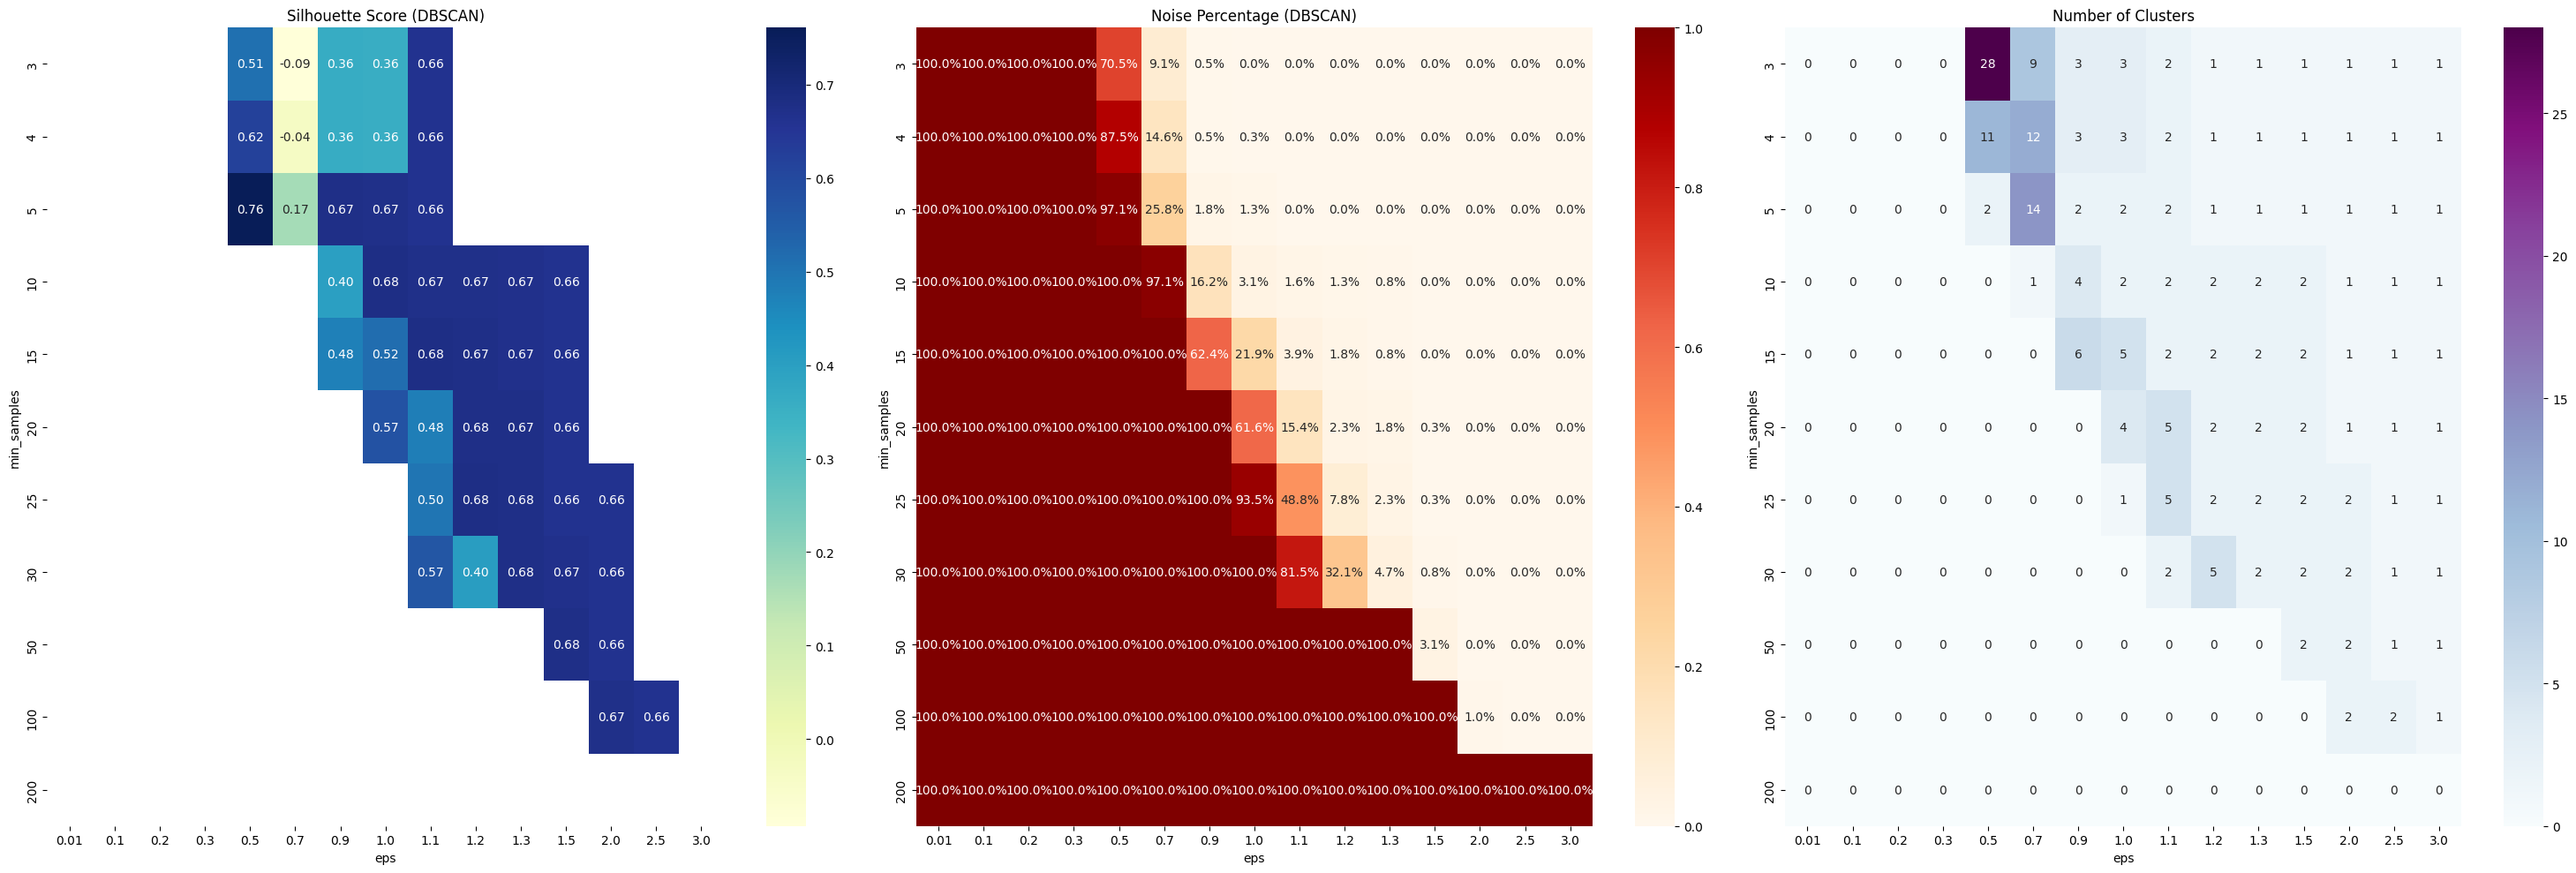

In [ ]:
pivot_sil = results_dbscan_df_M.pivot(index='min_samples', columns='eps', values='silhouette')
pivot_noise = results_dbscan_df_M.pivot(index='min_samples', columns='eps', values='noise_ratio')
pivot_clusters = results_dbscan_df_M.pivot(index='min_samples', columns='eps', values='n_clusters')

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Plot 1: Silhouette Score (DBSCAN)
sns.heatmap(pivot_sil, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Silhouette Score (DBSCAN)')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('min_samples')

# Plot 2: Noise Percentage
sns.heatmap(pivot_noise, annot=True, fmt=".1%", cmap="OrRd", ax=axes[1])
axes[1].set_title('Noise Percentage (DBSCAN)')
axes[1].set_xlabel('eps')
axes[1].set_ylabel('min_samples')

#Plot 3: Number of Clusters
sns.heatmap(pivot_clusters, annot=True, fmt="d", cmap="BuPu", ax = axes[2])
axes[2].set_title('Number of Clusters')
axes[2].set_xlabel('eps')
axes[2].set_ylabel('min_samples')

plt.tight_layout()
plt.show()

In [ ]:
results_dbscan_HCC = []
# HCC dbscan after umap
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=8).fit(umap_embedding_HCC)
        labels = db.labels_

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)

        try:
            core_data = umap_embedding_HCC[labels != -1]
            core_labels = labels[labels != -1]
            silhouette = silhouette_score(core_data, core_labels)
        except:
            silhouette = np.nan
            db_score = np.nan

        results_dbscan_HCC.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette': silhouette,
        })



results_dbscan_df_H = pd.DataFrame(results_dbscan_HCC)
results_dbscan_df_H.iloc[-20:,:]

,eps,min_samples,n_clusters,n_noise,noise_ratio,silhouette
145,2.5,5,1,0,0.000000,NaN
146,2.5,10,1,0,0.000000,NaN
147,2.5,15,1,0,0.000000,NaN
148,2.5,20,1,0,0.000000,NaN
149,2.5,25,1,0,0.000000,NaN
150,2.5,30,1,0,0.000000,NaN
151,2.5,50,1,0,0.000000,NaN
152,2.5,100,1,0,0.000000,NaN
153,2.5,200,0,243,1.000000,NaN
154,3.0,3,1,0,0.000000,NaN


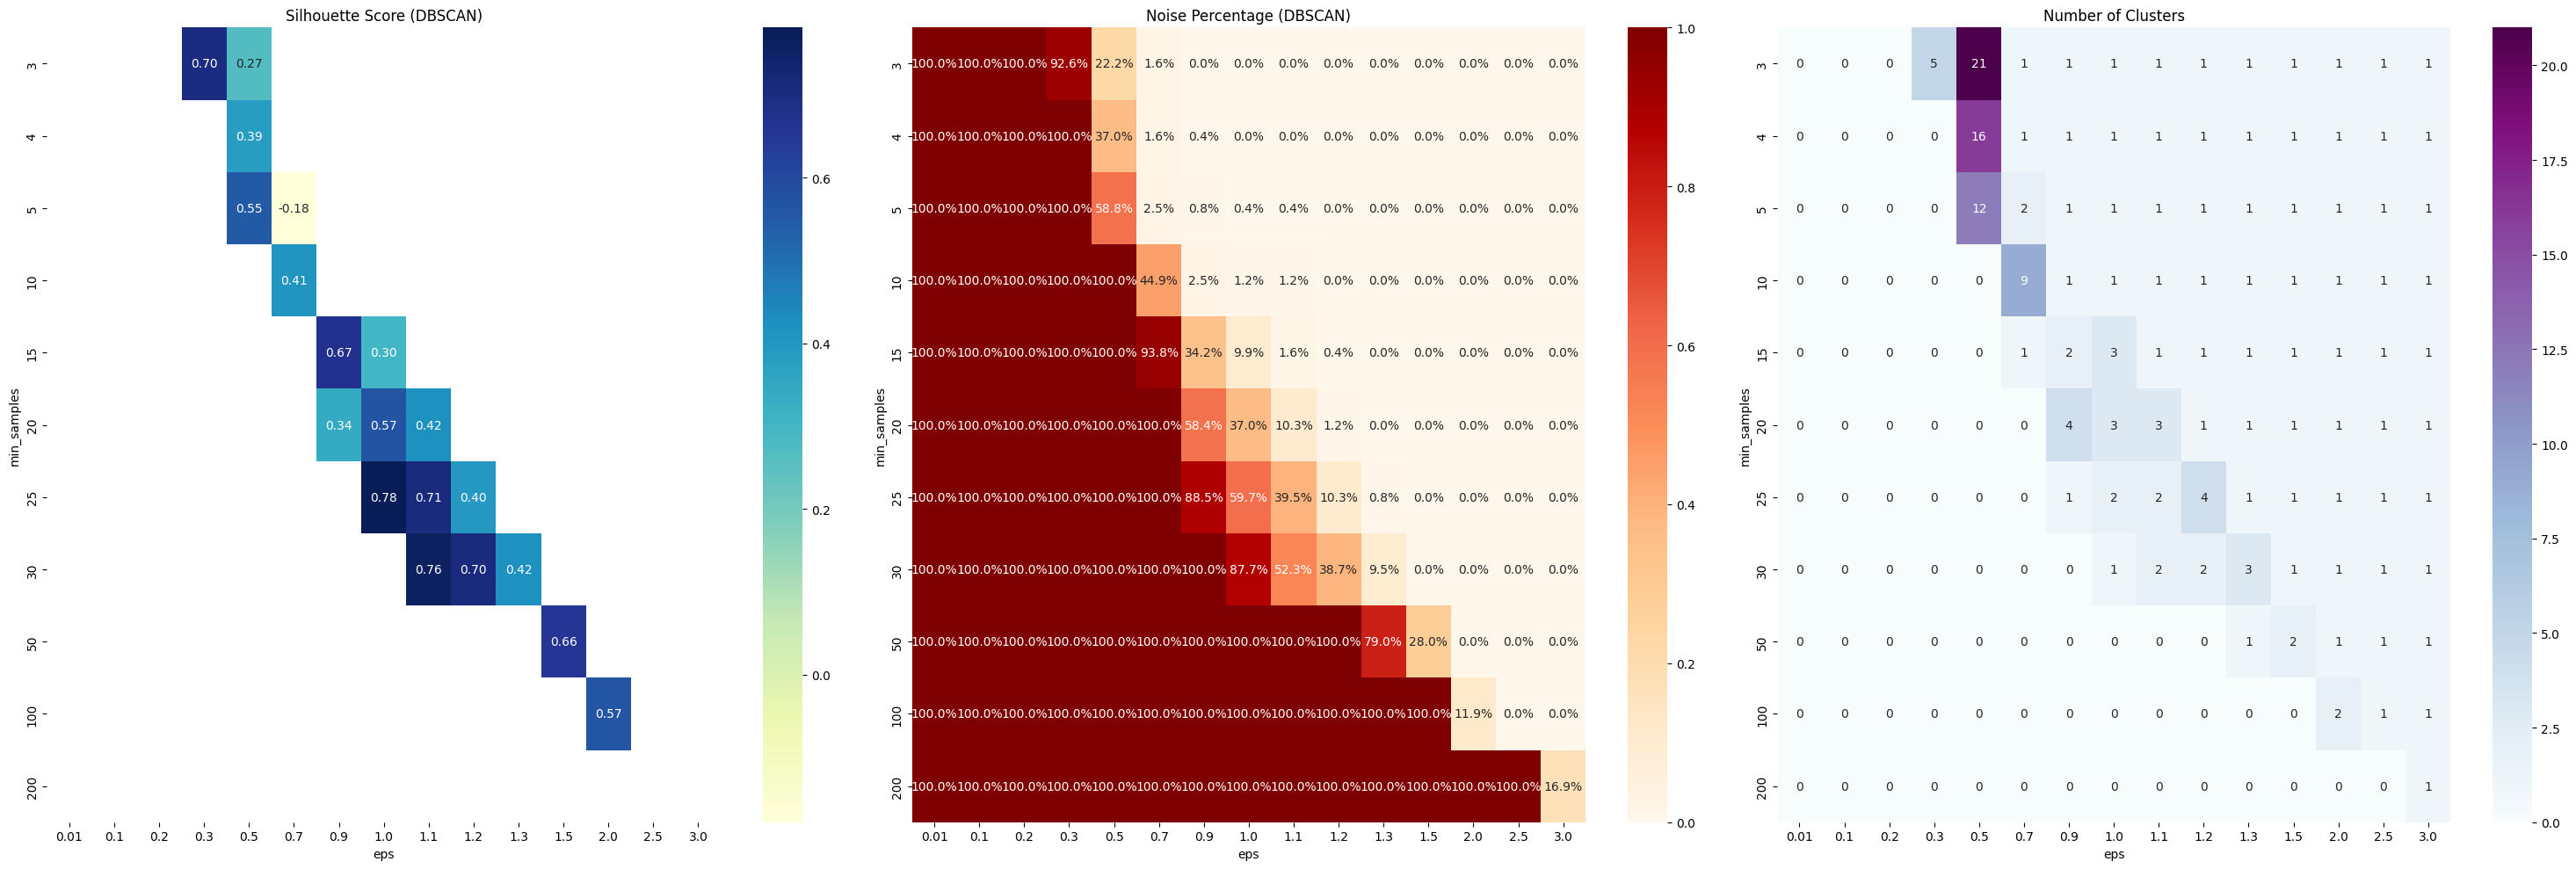

In [ ]:
pivot_sil = results_dbscan_df_H.pivot(index='min_samples', columns='eps', values='silhouette')
pivot_noise = results_dbscan_df_H.pivot(index='min_samples', columns='eps', values='noise_ratio')
pivot_clusters = results_dbscan_df_H.pivot(index='min_samples', columns='eps', values='n_clusters')

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Plot 1: Silhouette Score (DBSCAN)
sns.heatmap(pivot_sil, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Silhouette Score (DBSCAN)')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('min_samples')

# Plot 2: Noise Percentage
sns.heatmap(pivot_noise, annot=True, fmt=".1%", cmap="OrRd", ax=axes[1])
axes[1].set_title('Noise Percentage (DBSCAN)')
axes[1].set_xlabel('eps')
axes[1].set_ylabel('min_samples')

#Plot 3: Number of Clusters
sns.heatmap(pivot_clusters, annot=True, fmt="d", cmap="BuPu", ax = axes[2])
axes[2].set_title('Number of Clusters')
axes[2].set_xlabel('eps')
axes[2].set_ylabel('min_samples')

plt.tight_layout()
plt.show()

### K-means

In [ ]:
results_kmeans_HCC = []

# apply k-means to raw standardized data to see results
print("HCC186 dataset")
for init in initialisations:
    for n in n_init:
        k_mean = KMeans( n_clusters=2, init= init, n_init=n, random_state=20)
        k_mean.fit(umap_embedding_HCC)
        labels = k_mean.labels_

        try:
            core_data = umap_embedding_HCC[labels != -1]
            core_labels = labels[labels != -1]
            silhouette = silhouette_score(core_data, core_labels)
        except:
            silhouette = np.nan

        results_kmeans_HCC.append({
            'n_init': n,
            "initialisations": init,
            'silhouette': silhouette,
        })


results_kmeans_df_H = pd.DataFrame(results_kmeans_HCC)
results_kmeans_df_H.iloc[-20:,:]

HCC186 dataset


,n_init,initialisations,silhouette
0,1,k-means++,0.498312
1,5,k-means++,0.497689
2,10,k-means++,0.497689
3,1,random,0.497689
4,5,random,0.497689
5,10,random,0.497689


In [ ]:
results_kmeans_MCF7 = []

# apply k-means to raw standardized data to see results
print("MCF7 dataset")
for init in initialisations:
    for n in n_init:
        k_mean = KMeans( n_clusters=2, init= init, n_init=n, random_state=20)
        k_mean.fit(umap_embedding_MCF7)
        labels = k_mean.labels_

        try:
            core_data = umap_embedding_MCF7[labels != -1]
            core_labels = labels[labels != -1]
            silhouette = silhouette_score(core_data, core_labels)
        except:
            silhouette = np.nan

        results_kmeans_MCF7.append({
            'n_init': n,
            "initialisations": init,
            'silhouette': silhouette,
        })


results_kmeans_df_M = pd.DataFrame(results_kmeans_MCF7)
results_kmeans_df_M.iloc[-20:,:]

MCF7 dataset


,n_init,initialisations,silhouette
0,1,k-means++,0.663397
1,5,k-means++,0.663397
2,10,k-means++,0.663397
3,1,random,0.663397
4,5,random,0.663397
5,10,random,0.663397


## Silhouette score/Accuracy vs n-components of UMAP for K-means on HCC dataset

In [ ]:
# draw graphs for varying number of components for k-means
n_comps = [2,3,4,5,10,25,50,75,100]
results_comp_anal = []
for comp in n_comps:
    umaps_HCC = umap.UMAP(
    n_neighbors=43,
    min_dist=0.67,
    metric="cosine",
    n_components=comp,
    random_state=42)
    umap_embeddings_H = umaps_HCC.fit_transform(df_HCC.values)
    #find clusters with k-means
    k_mean = KMeans( n_clusters=2, init= "k-means++", n_init=5, random_state=20)
    k_mean.fit(umap_embeddings_H)
    labels = k_mean.labels_

    results_comp_anal.append({
        'n_comps': comp,
        'silhouette': silhouette_score(umap_embeddings_H, labels),
        'accuracy' : max(accuracy_score(labels, condition_labels_HCC), 1-accuracy_score(labels, condition_labels_HCC))
    })

results_comp_kmeans_H = pd.DataFrame(results_comp_anal)
results_comp_kmeans_H.head(10)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: Futu

,n_comps,silhouette,accuracy
0,2,0.490038,0.925926
1,3,0.407186,0.917695
2,4,0.375496,0.913580
3,5,0.381279,0.921811
4,10,0.381718,0.913580
5,25,0.381752,0.909465
6,50,0.372193,0.909465
7,75,0.378272,0.913580
8,100,0.377095,0.909465


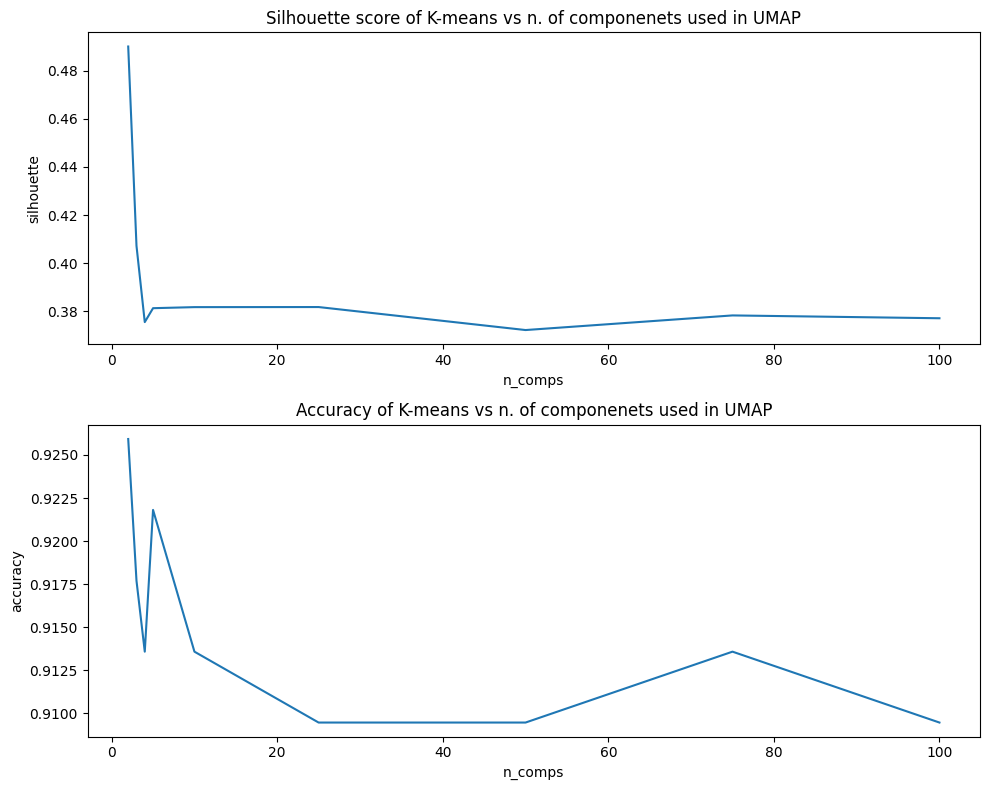

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(10,8))
#plot accuracy of K-means vs n. of components
sns.lineplot(x="n_comps", y= "silhouette" , data=results_comp_kmeans_H, ax = axes[0])
axes[0].set_title("Silhouette score of K-means vs n. of componenets used in UMAP")
sns.lineplot(x="n_comps", y= "accuracy" , data=results_comp_kmeans_H, ax = axes[1])
axes[1].set_title("Accuracy of K-means vs n. of componenets used in UMAP")
plt.tight_layout()
plt.show()

For k-means, the performance seems to mostly independent of the number of components for the accuracy and instead the silhouette score is maximised for 2/3 components so one might as well use 2 components since they require less storage space and computations

Moreover, despite this notebook is part of the unsupervised analysis of the datasets, we also compute and plot the accuracy for k-means in order to understand whether it would make sense to first cluster the training dataset and then train the predictors based on the matrix of distances from the centroids

## Computing UMAP 2d and 3d embeddings

In [ ]:
print("Computing UMAP 2D...")
umap_2d_HCC = umap.UMAP(
    n_neighbors=18, min_dist=0.306, metric = "correlation",
    n_components=2,
    random_state=42
)
umap_2d_MCF7 = umap.UMAP(
    n_neighbors=26, min_dist=0.53, metric = "correlation",
    n_components=2,
    random_state=42
)
umap_embedding_2d_H = umap_2d_HCC.fit_transform(df_HCC.values)
umap_embedding_2d_M = umap_2d_MCF7.fit_transform(df_MCF7.values)

Computing UMAP 2D...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
print("Computing UMAP 3D...")
umap_3d_HCC = umap.UMAP(
    n_neighbors=18, min_dist=0.306, metric = "correlation",
    n_components=3,
    random_state=42
)
umap_3d_MCF7 = umap.UMAP(
    n_neighbors=26, min_dist=0.53, metric = "correlation",
    n_components=3,
    random_state=42
)
umap_embedding_3d_H = umap_3d_HCC.fit_transform(df_HCC.values)
umap_embedding_3d_M = umap_3d_MCF7.fit_transform(df_MCF7.values)

Computing UMAP 3D...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## ANALYSIS OF DBSCAN WITH HYRBID METRIC

Now we will define an hybrid metrica that combines 3 things:
- silhoutte score (the higher the better): (we normalizaite it so [0,1] summing 1 and dividing by 2)
- noise_ratio (the lower the better): we invert it [0,1] via 1-noise_ratio
- n_clusters (we accept only 2)

In the next cells we will call it this metric "score"

"score" belongs to the interval [0,2]. Values around 2 are considered very good.

if n_clusters >= 2:
    score = (silhouette + 1)/2 + (1 - noise_ratio)
else:
    score = 0

In [ ]:
#based on above findings apply DBSCAN to UMAP emebedding with only two clusters
results_dbscan_HCC = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=8).fit(umap_embedding_3d_H)
        labels = db.labels_

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)

        try:
            core_data = umap_embedding_3d_H[labels != -1]
            core_labels = labels[labels != -1]
            silhouette = silhouette_score(core_data, core_labels)
        except:
            silhouette = np.nan
            db_score = np.nan

        results_dbscan_HCC.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette': silhouette,
            "score": ((silhouette + 1)/2 + (1-noise_ratio)) if n_clusters >= 2 else 0
        })

results_dbscan_df_H = pd.DataFrame(results_dbscan_HCC)
results_dbscan_df_H.iloc[-20:,:]

,eps,min_samples,n_clusters,n_noise,noise_ratio,silhouette,score
145,2.5,5,1,0,0.000000,NaN,0.0
146,2.5,10,1,0,0.000000,NaN,0.0
147,2.5,15,1,0,0.000000,NaN,0.0
148,2.5,20,1,0,0.000000,NaN,0.0
149,2.5,25,1,0,0.000000,NaN,0.0
150,2.5,30,1,0,0.000000,NaN,0.0
151,2.5,50,1,0,0.000000,NaN,0.0
152,2.5,100,1,0,0.000000,NaN,0.0
153,2.5,200,0,243,1.000000,NaN,0.0
154,3.0,3,1,0,0.000000,NaN,0.0


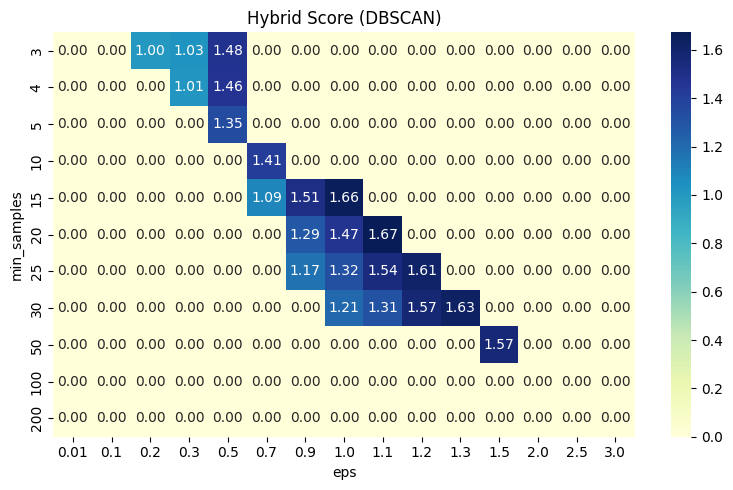

In [ ]:
pivot_sil = results_dbscan_df_H.pivot(index='min_samples', columns='eps', values='score')
# pivot_noise = results_dbscan_df_H.pivot(index='min_samples', columns='eps', values='noise_ratio')
# pivot_clusters = results_dbscan_df_H.pivot(index='min_samples', columns='eps', values='n_clusters')

fig, axes = plt.subplots(1, 1, figsize=(8, 5))

# Plot 1: Silhouette Score (DBSCAN)
sns.heatmap(pivot_sil, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes)
axes.set_title('Hybrid Score (DBSCAN)')
axes.set_xlabel('eps')
axes.set_ylabel('min_samples')

plt.tight_layout()
plt.show()

We notice high values with combinations of eps and min_sample that are coherent with what we obeseved before.

In [ ]:
#based on above findings apply DBSCAN to UMAP emebedding with only two clusters
results_dbscan_MC = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=8).fit(umap_embedding_3d_M)
        labels = db.labels_

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)

        try:
            core_data = umap_embedding_3d_M[labels != -1]
            core_labels = labels[labels != -1]
            silhouette = silhouette_score(core_data, core_labels)
        except:
            silhouette = np.nan
            db_score = np.nan

        results_dbscan_MC.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette': silhouette,
            "score": ((silhouette + 1)/2 + (1-noise_ratio)) if n_clusters >= 2 else 0
        })

results_dbscan_df_MC = pd.DataFrame(results_dbscan_MC)
results_dbscan_df_MC.iloc[-20:,:]

,eps,min_samples,n_clusters,n_noise,noise_ratio,silhouette,score
145,2.5,5,1,0,0.0,NaN,0.000000
146,2.5,10,1,0,0.0,NaN,0.000000
147,2.5,15,1,0,0.0,NaN,0.000000
148,2.5,20,1,0,0.0,NaN,0.000000
149,2.5,25,1,0,0.0,NaN,0.000000
150,2.5,30,1,0,0.0,NaN,0.000000
151,2.5,50,1,0,0.0,NaN,0.000000
152,2.5,100,2,0,0.0,0.63537,1.817685
153,2.5,200,0,383,1.0,NaN,0.000000
154,3.0,3,1,0,0.0,NaN,0.000000


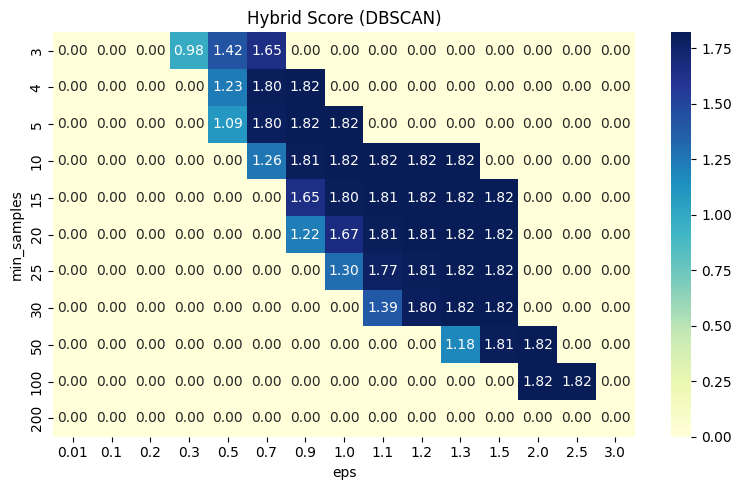

In [ ]:
pivot_sil = results_dbscan_df_MC.pivot(index='min_samples', columns='eps', values='score')
# pivot_noise = results_dbscan_df_H.pivot(index='min_samples', columns='eps', values='noise_ratio')
# pivot_clusters = results_dbscan_df_H.pivot(index='min_samples', columns='eps', values='n_clusters')

fig, axes = plt.subplots(1, 1, figsize=(8, 5))

# Plot 1: Silhouette Score (DBSCAN)
sns.heatmap(pivot_sil, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes)
axes.set_title('Hybrid Score (DBSCAN)')
axes.set_xlabel('eps')
axes.set_ylabel('min_samples')

plt.tight_layout()
plt.show()

We notice high values with combinations of eps and min_sample that are coherent with what we obeseved before.

## Silhouette score plots for number of natural clusters (detecting NOISE/OUTLIER analysis)

Using the clustering results of the K-means algorithm with different number of components to evaluate if there is so much noise in the data to form an indpendent cluster (as was, probably mistakenly, suggested a bit by isolation forest)

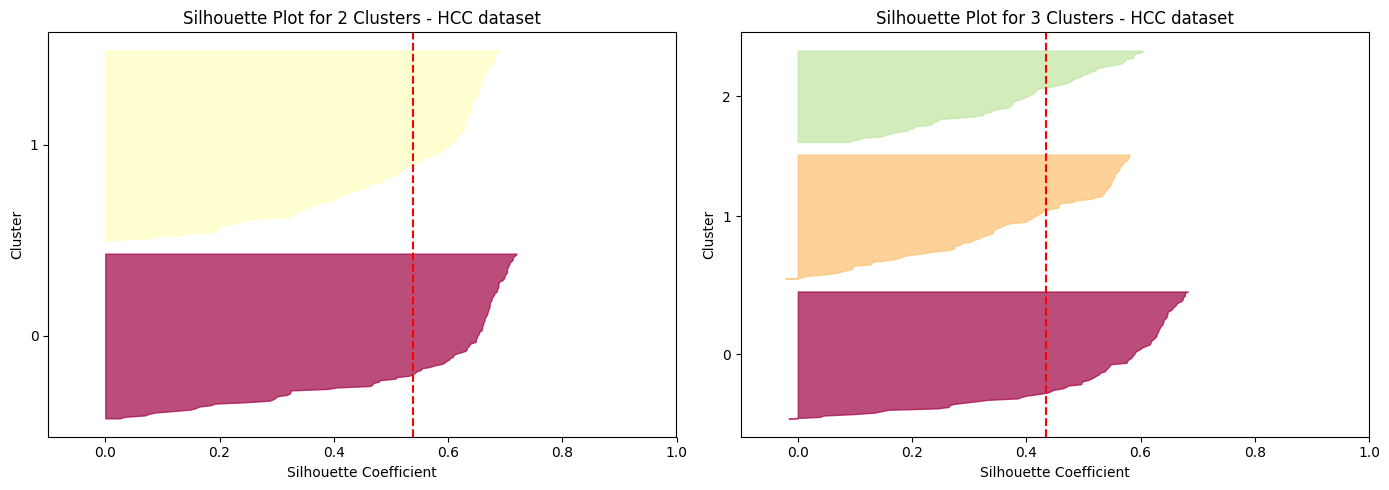

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.ticker import FixedLocator, FixedFormatter

# First, define a function to plot silhouette for a given number of clusters
def plot_silhouette(ax, embedding, n_clusters, title_suffix=""):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=5, random_state=20).fit(embedding)
    labels = kmeans.labels_
    silhouette_coefficients = silhouette_samples(embedding, labels)
    avg_score = silhouette_score(embedding, labels)

    # Only one plot since you have k clusters
    padding = len(embedding) // 30
    pos = padding
    ticks = []

    for i in range(n_clusters):
        coeffs = silhouette_coefficients[labels == i]
        coeffs.sort()
        color = plt.cm.Spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    # Customize axis
    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_formatter(FixedFormatter(range(n_clusters)))
    ax.set_ylabel("Cluster")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_title(f"Silhouette Plot for {n_clusters} Clusters - HCC dataset")
    ax.axvline(x=avg_score, color="red", linestyle="--")
    ax.set_xlim([-0.1, 1])

# Create subplots for 2 and 3 clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Assuming `umap_embedding_3d_H` is defined
plot_silhouette(ax1, umap_embedding_2d_H, 2)
plot_silhouette(ax2, umap_embedding_2d_H, 3)

plt.tight_layout()
plt.show()

The plot shows better results with 2 clusters: the slihoutte score of each sample is higher compared to the one with 3 clusters. Thus we can say that there are naturally 2 clusters rather than 2 clusters + 1 of noise

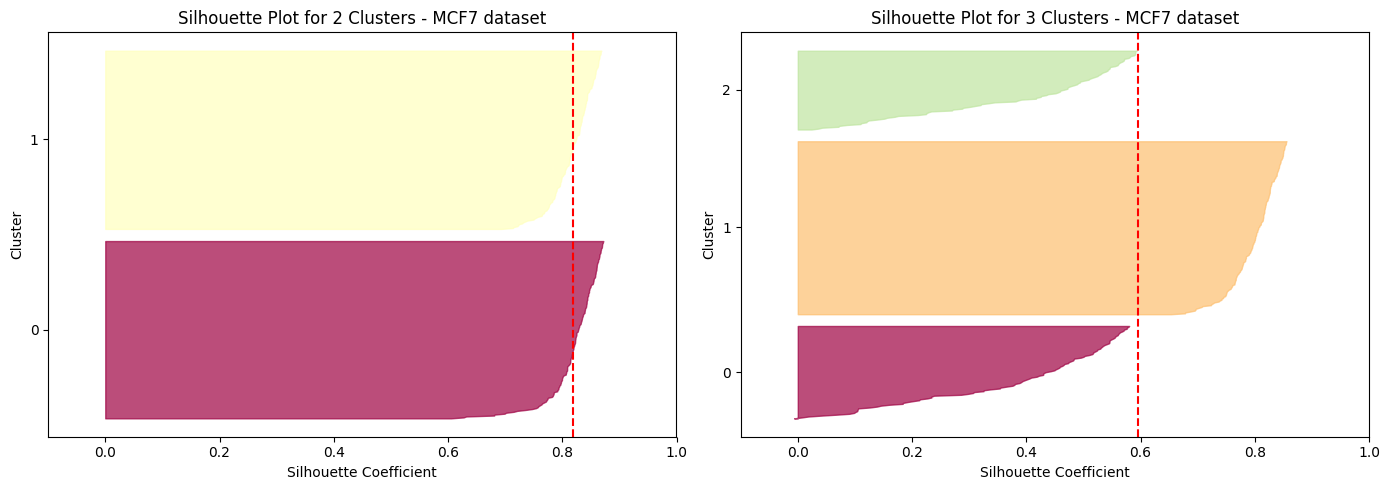

In [ ]:
# First, define a function to plot silhouette for a given number of clusters
def plot_silhouette(ax, embedding, n_clusters, title_suffix=""):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=5, random_state=20).fit(embedding)
    labels = kmeans.labels_
    silhouette_coefficients = silhouette_samples(embedding, labels)
    avg_score = silhouette_score(embedding, labels)

    # Only one plot since you have k clusters
    padding = len(embedding) // 30
    pos = padding
    ticks = []

    for i in range(n_clusters):
        coeffs = silhouette_coefficients[labels == i]
        coeffs.sort()
        color = plt.cm.Spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    # Customize axis
    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_formatter(FixedFormatter(range(n_clusters)))
    ax.set_ylabel("Cluster")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_title(f"Silhouette Plot for {n_clusters} Clusters - MCF7 dataset")
    ax.axvline(x=avg_score, color="red", linestyle="--")
    ax.set_xlim([-0.1, 1])

# Create subplots for 2 and 3 clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Assuming `umap_embedding_3d_H` is defined
plot_silhouette(ax1, umap_embedding_2d_M, 2)
plot_silhouette(ax2, umap_embedding_2d_M, 3)

plt.tight_layout()
plt.show()

The plot shows better results with 2 clusters: the slihoutte score of each sample is higher compared to the one with 3 clusters. Thus we can say that there are naturally 2 clusters rather than 2 clusters + 1 of noise

# Visualisation of predicted and true clusters after UMAP

In [ ]:
#best clustering algorithms on UMAP
dbscan_H_umap = DBSCAN(eps=1.2, min_samples=20, n_jobs=8).fit(umap_embedding_HCC)
labels_dbscan_H = dbscan_H_umap.labels_
colors_dbscan_H = ["green" if c == 0 else "yellow" if c == 1 else "black" for c in labels_dbscan_H]

dbscan_M_umap = DBSCAN(eps=1.3, min_samples=10, n_jobs=8).fit(umap_embedding_MCF7)
labels_dbscan_M = dbscan_M_umap.labels_
colors_dbscan_M = ["green" if c == 0 else "yellow" if c == 1 else "black" for c in labels_dbscan_M]


kmeans_H_umap = KMeans(n_clusters=2, init= "k-means++", n_init= 5, random_state=20).fit(umap_embedding_2d_H)
labels_kmeans_H = kmeans_H_umap.labels_
colors_kmeans_H = ["green" if c == 0 else "yellow" if c == 1 else "black" for c in labels_kmeans_H]

kmeans_M_umap = KMeans(n_clusters=2, init= "k-means++", n_init= 1, random_state=20).fit(umap_embedding_MCF7)
labels_kmeans_M = kmeans_M_umap.labels_
colors_kmeans_M = ["green" if c == 0 else "yellow" if c == 1 else "black" for c in labels_kmeans_M]

In [ ]:
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=12, label='Norm'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=12, label='Hypo')
]

In [ ]:
legend_elements_2 = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=12, label='Cluster 1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=12, label='Cluster 2'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=12, label='Noise')
]

In [ ]:
legend_elements_3 = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=12, label='Cluster 1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=12, label='Cluster 2'),
]

## HCC DATASET

Plotting the first two componnets of UMAP with 125 components would result in bad visualisation in 2d and so umap 2d embedding is better to compress and show effectively the info in two components

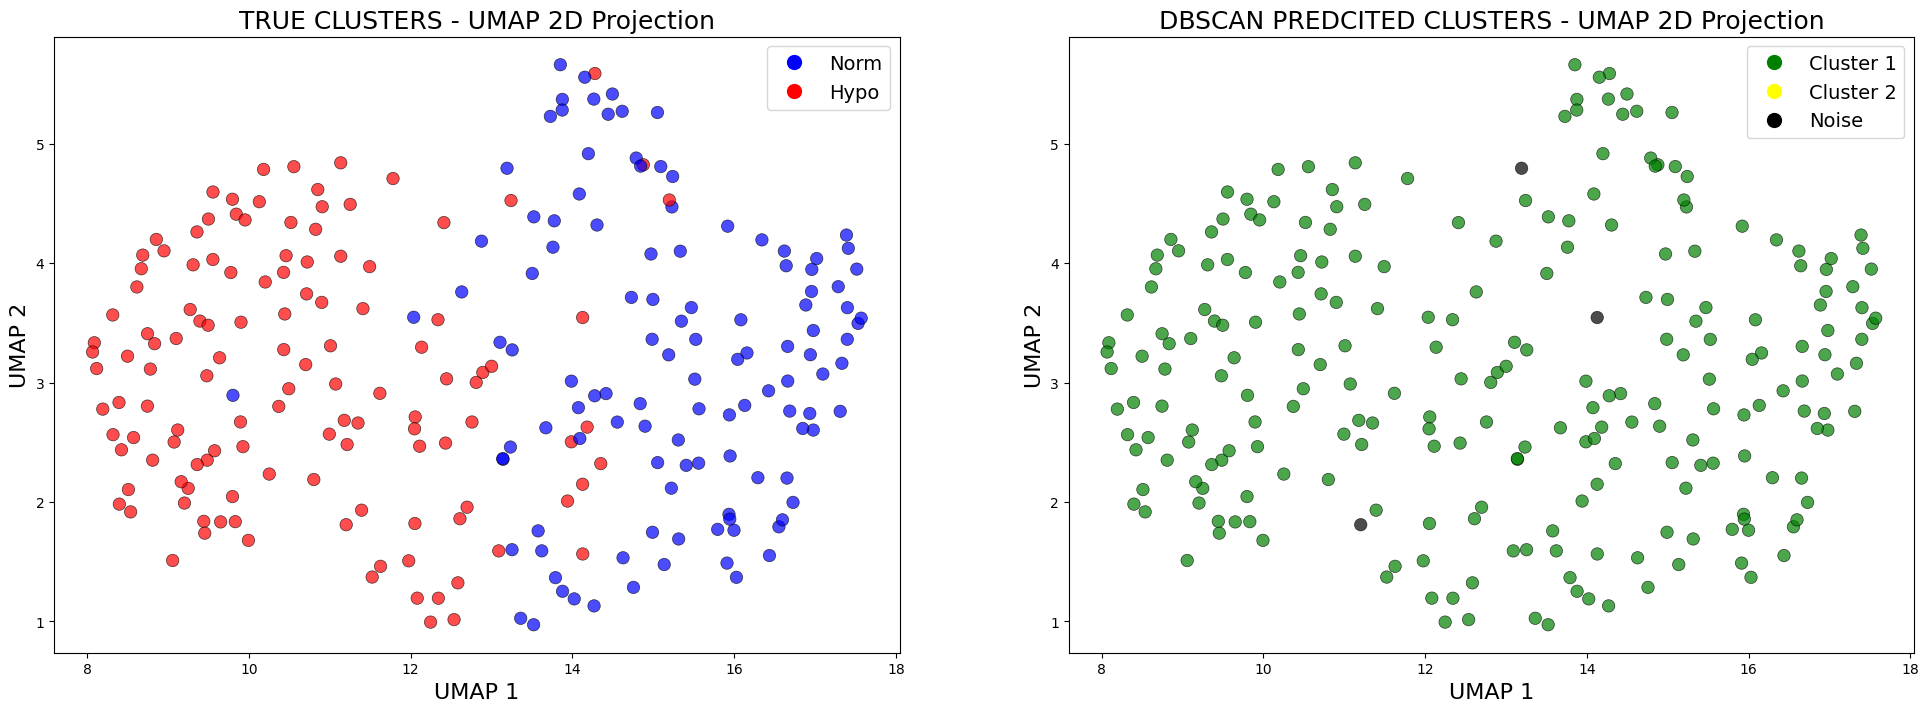

In [ ]:
# Visualize 2D projections side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes_flat = axes.flatten()
# UMAP 2D
axes_flat[0].scatter(umap_embedding_2d_H[:, 0], umap_embedding_2d_H[:, 1], s=80, alpha=0.7, c=colors_HCC, edgecolor='k', linewidth=0.5)
axes_flat[0].set_xlabel("UMAP 1", fontsize=16)
axes_flat[0].set_ylabel("UMAP 2", fontsize=16)
axes_flat[0].set_title("TRUE CLUSTERS - UMAP 2D Projection", fontsize=18)
axes_flat[0].legend(handles=legend_elements, loc='best', fontsize=14)

axes_flat[1].scatter(umap_embedding_2d_H[:, 0], umap_embedding_2d_H[:, 1], s=80, alpha=0.7, c=colors_dbscan_H, edgecolor='k', linewidth=0.5)
axes_flat[1].set_xlabel("UMAP 1", fontsize=16)
axes_flat[1].set_ylabel("UMAP 2", fontsize=16)
axes_flat[1].set_title("DBSCAN PREDCITED CLUSTERS - UMAP 2D Projection", fontsize=18)
axes_flat[1].legend(handles=legend_elements_2, loc='best', fontsize=14)

plt.show()

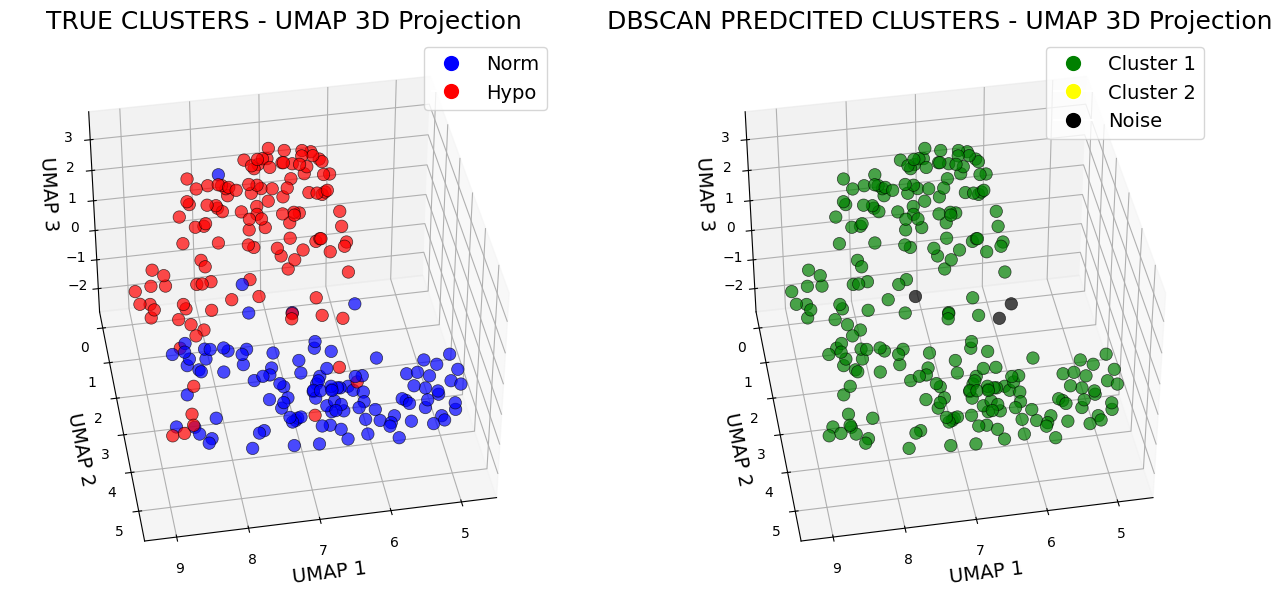

In [ ]:
# Visualize 3D projections side by side
fig = plt.figure(figsize=(24, 8))

# UMAP 3D
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(
    umap_embedding_3d_H[:, 0],
    umap_embedding_3d_H[:, 1],
    umap_embedding_3d_H[:, 2],
    c=colors_HCC, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax1.set_xlabel("UMAP 1", fontsize=14)
ax1.set_ylabel("UMAP 2", fontsize=14)
ax1.set_zlabel("UMAP 3", fontsize=14)
ax1.set_title("TRUE CLUSTERS - UMAP 3D Projection", fontsize=18)
ax1.view_init(elev=40, azim=80)
ax1.legend(handles=legend_elements, loc='upper right', fontsize=14)

# t-SNE 3D
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(
    umap_embedding_3d_H[:, 0],
    umap_embedding_3d_H[:, 1],
    umap_embedding_3d_H[:, 2],
    c=colors_dbscan_H, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax2.set_xlabel("UMAP 1", fontsize=14)
ax2.set_ylabel("UMAP 2", fontsize=14)
ax2.set_zlabel("UMAP 3", fontsize=14)
ax2.set_title("DBSCAN PREDCITED CLUSTERS - UMAP 3D Projection", fontsize=18)
ax2.view_init(elev=40, azim=80)
ax2.legend(handles=legend_elements_2, loc='upper right', fontsize=14)

plt.show()

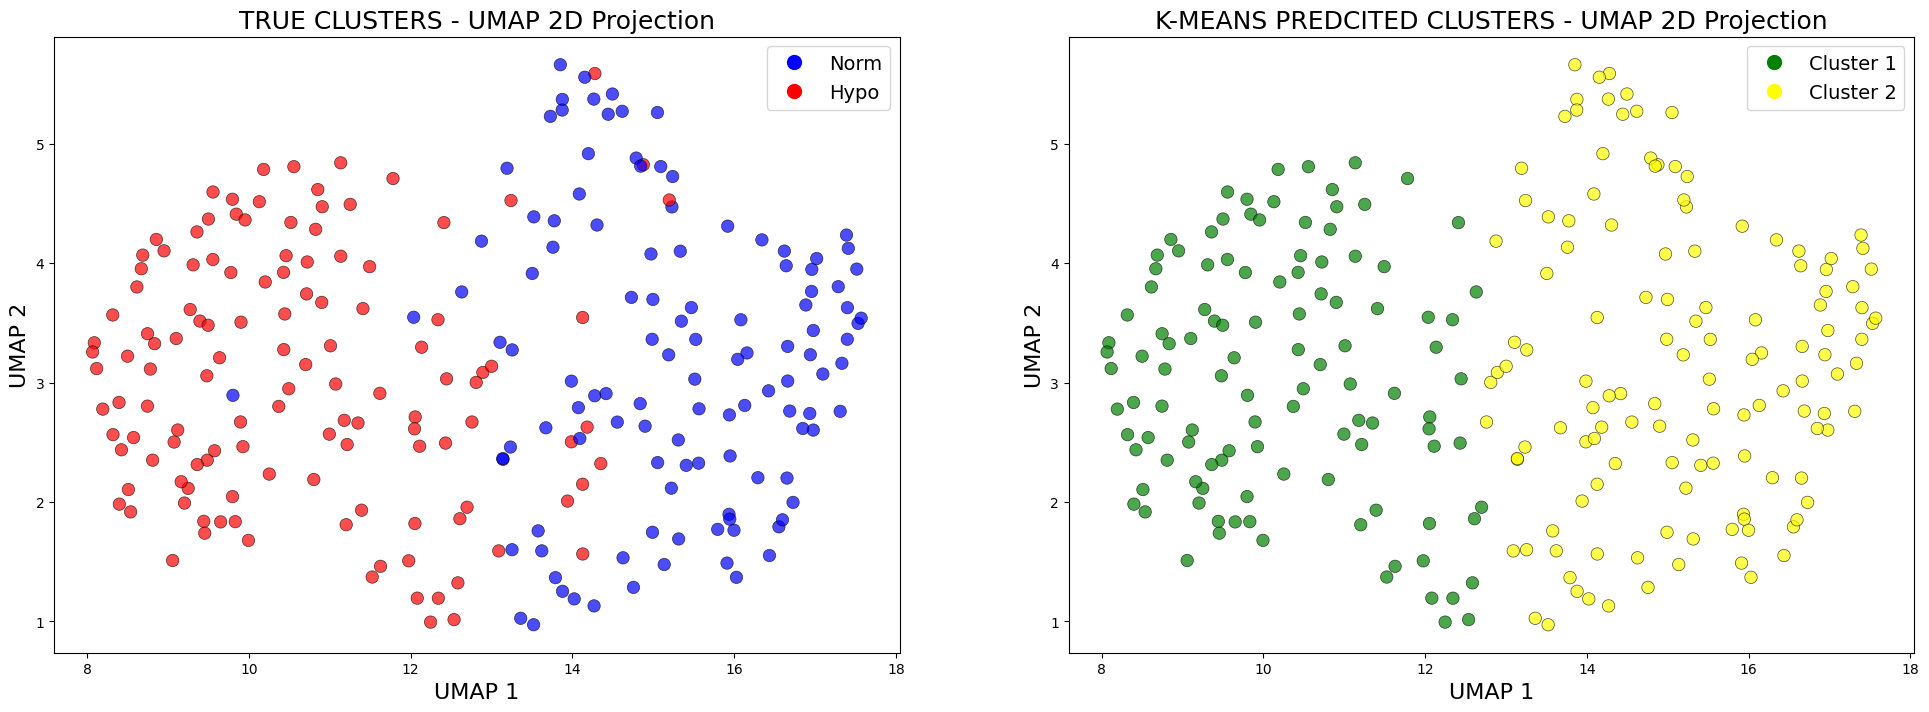

In [ ]:
# Visualize 2D projections side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# UMAP 2D
axes[0].scatter(umap_embedding_2d_H[:, 0], umap_embedding_2d_H[:, 1], s=80, alpha=0.7, c=colors_HCC, edgecolor='k', linewidth=0.5)
axes[0].set_xlabel("UMAP 1", fontsize=16)
axes[0].set_ylabel("UMAP 2", fontsize=16)
axes[0].set_title("TRUE CLUSTERS - UMAP 2D Projection", fontsize=18)
axes[0].legend(handles=legend_elements, loc='best', fontsize=14)

axes[1].scatter(umap_embedding_2d_H[:, 0], umap_embedding_2d_H[:, 1], s=80, alpha=0.7, c=colors_kmeans_H, edgecolor='k', linewidth=0.5)
axes[1].set_xlabel("UMAP 1", fontsize=16)
axes[1].set_ylabel("UMAP 2", fontsize=16)
axes[1].set_title("K-MEANS PREDCITED CLUSTERS - UMAP 2D Projection", fontsize=18)
axes[1].legend(handles=legend_elements_3, loc='best', fontsize=14)


plt.show()

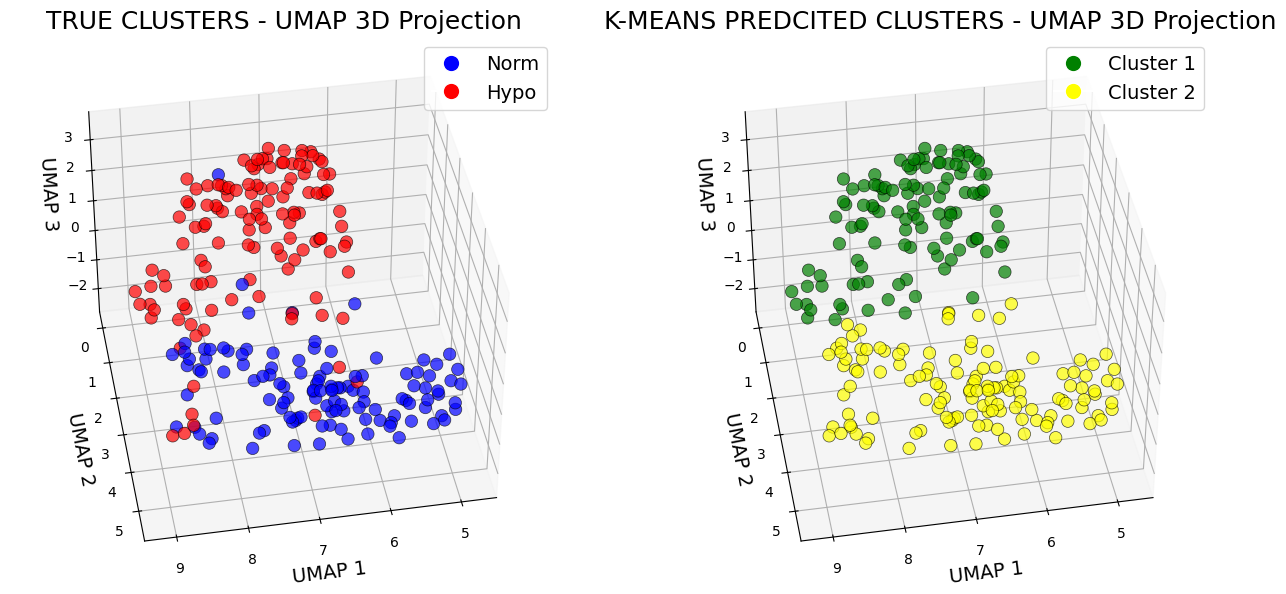

In [ ]:
# Visualize 3D projections side by side
fig = plt.figure(figsize=(24, 8))

# UMAP 3D
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(
    umap_embedding_3d_H[:, 0],
    umap_embedding_3d_H[:, 1],
    umap_embedding_3d_H[:, 2],
    c=colors_HCC, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax1.set_xlabel("UMAP 1", fontsize=14)
ax1.set_ylabel("UMAP 2", fontsize=14)
ax1.set_zlabel("UMAP 3", fontsize=14)
ax1.set_title("TRUE CLUSTERS - UMAP 3D Projection", fontsize=18)
ax1.view_init(elev=40, azim=80)
ax1.legend(handles=legend_elements, loc='upper right', fontsize=14)

# t-SNE 3D
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(
    umap_embedding_3d_H[:, 0],
    umap_embedding_3d_H[:, 1],
    umap_embedding_3d_H[:, 2],
    c=colors_kmeans_H, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax2.set_xlabel("UMAP 1", fontsize=14)
ax2.set_ylabel("UMAP 2", fontsize=14)
ax2.set_zlabel("UMAP 3", fontsize=14)
ax2.set_title("K-MEANS PREDCITED CLUSTERS - UMAP 3D Projection", fontsize=18)
ax2.view_init(elev=40, azim=80)
ax2.legend(handles=legend_elements_3, loc='upper right', fontsize=14)

plt.show()

## MCF7 dataset

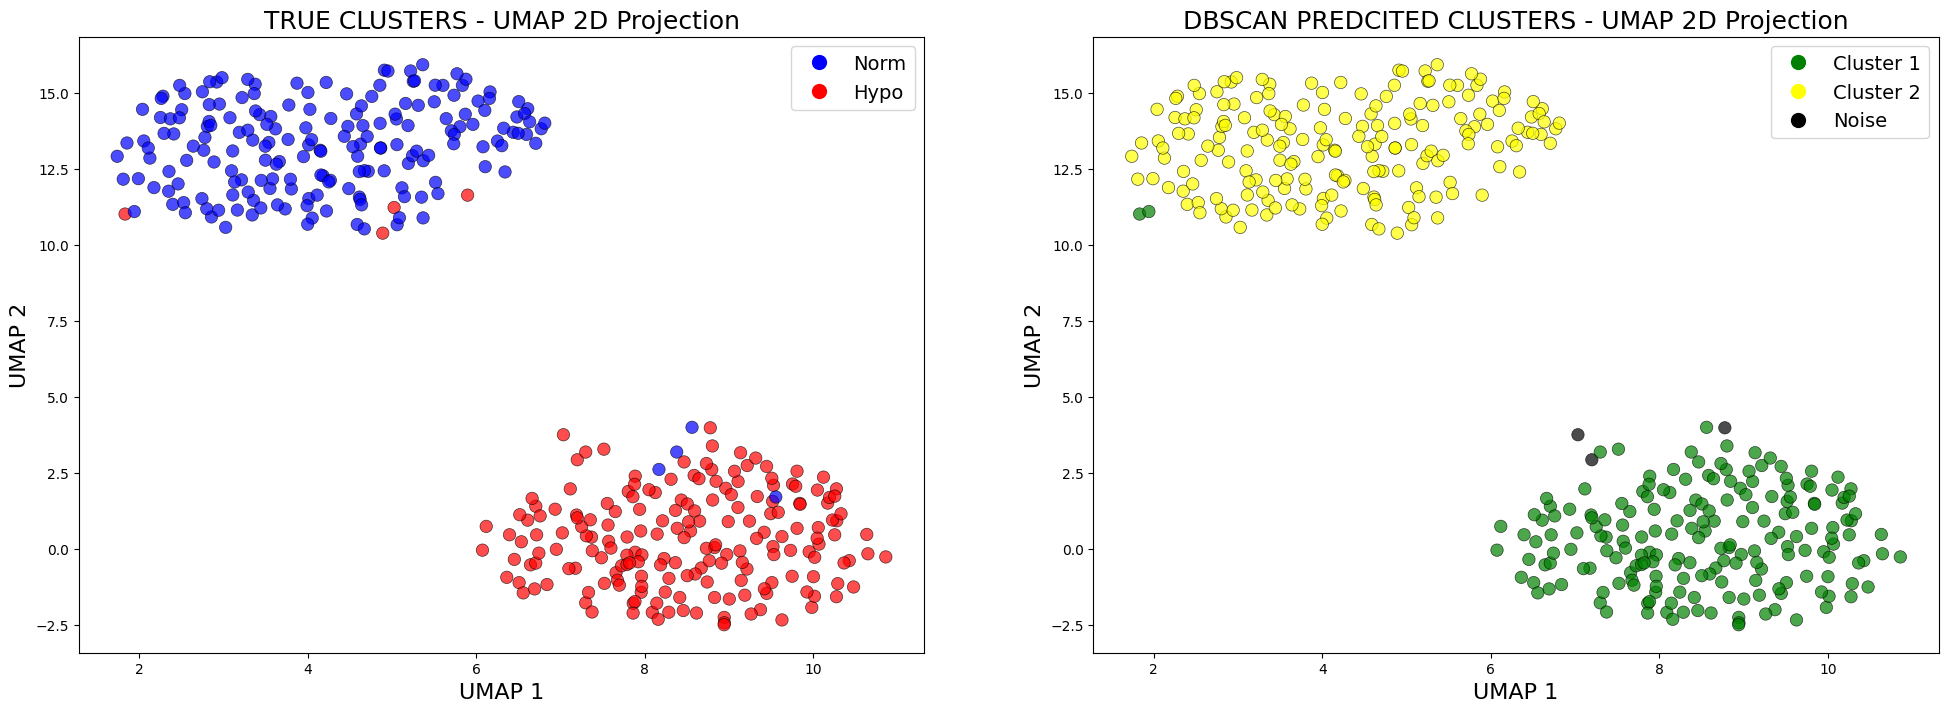

In [ ]:
# Visualize 2D projections side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# UMAP 2D
axes[0].scatter(umap_embedding_2d_M[:, 0], umap_embedding_2d_M[:, 1], s=80, alpha=0.7, c=colors_MCF7, edgecolor='k', linewidth=0.5)
axes[0].set_xlabel("UMAP 1", fontsize=16)
axes[0].set_ylabel("UMAP 2", fontsize=16)
axes[0].set_title("TRUE CLUSTERS - UMAP 2D Projection", fontsize=18)
axes[0].legend(handles=legend_elements, loc='best', fontsize=14)

axes[1].scatter(umap_embedding_2d_M[:, 0], umap_embedding_2d_M[:, 1], s=80, alpha=0.7, c=colors_dbscan_M, edgecolor='k', linewidth=0.5)
axes[1].set_xlabel("UMAP 1", fontsize=16)
axes[1].set_ylabel("UMAP 2", fontsize=16)
axes[1].set_title("DBSCAN PREDCITED CLUSTERS - UMAP 2D Projection", fontsize=18)
axes[1].legend(handles=legend_elements_2, loc='best', fontsize=14)
plt.show()

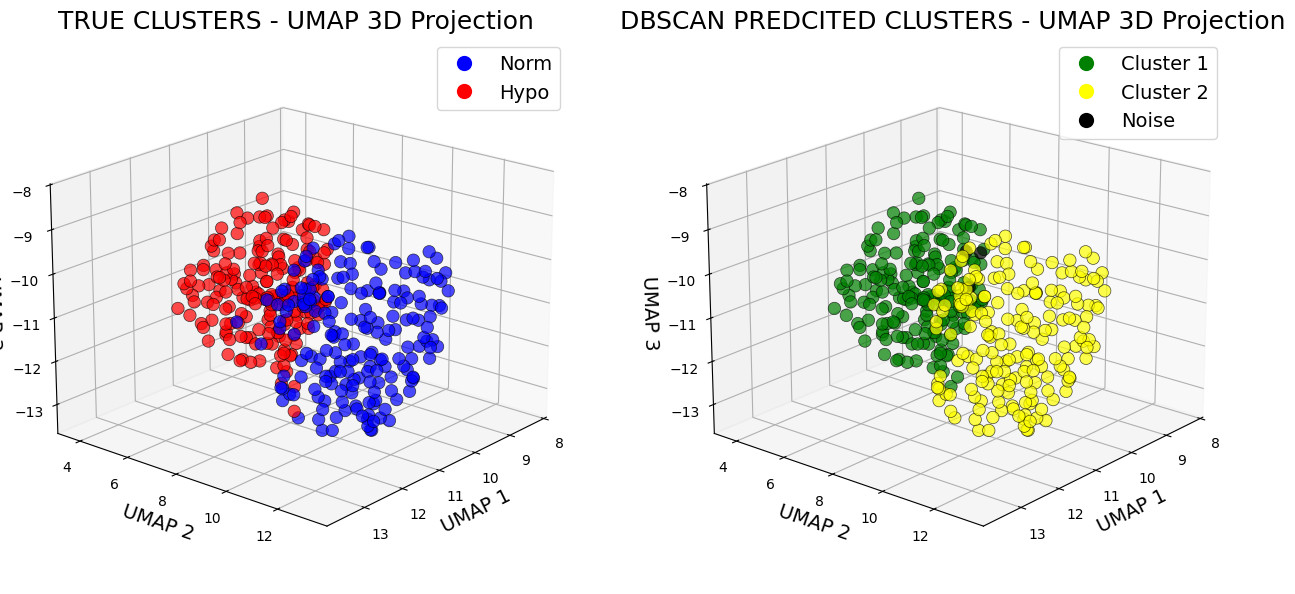

In [ ]:
# Visualize 3D projections side by side
fig = plt.figure(figsize=(24, 8))

# UMAP 3D
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(
    umap_embedding_3d_M[:, 0],
    umap_embedding_3d_M[:, 1],
    umap_embedding_3d_M[:, 2],
    c=colors_MCF7, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax1.set_xlabel("UMAP 1", fontsize=14)
ax1.set_ylabel("UMAP 2", fontsize=14)
ax1.set_zlabel("UMAP 3", fontsize=14)
ax1.set_title("TRUE CLUSTERS - UMAP 3D Projection", fontsize=18)
ax1.view_init(elev=20, azim=40)
ax1.legend(handles=legend_elements, loc='upper right', fontsize=14)

# t-SNE 3D
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(
    umap_embedding_3d_M[:, 0],
    umap_embedding_3d_M[:, 1],
    umap_embedding_3d_M[:, 2],
    c=colors_dbscan_M, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax2.set_xlabel("UMAP 1", fontsize=14)
ax2.set_ylabel("UMAP 2", fontsize=14)
ax2.set_zlabel("UMAP 3", fontsize=14)
ax2.set_title("DBSCAN PREDCITED CLUSTERS - UMAP 3D Projection", fontsize=18)
ax2.view_init(elev=20, azim=40)
ax2.legend(handles=legend_elements_2, loc='upper right', fontsize=14)

plt.show()

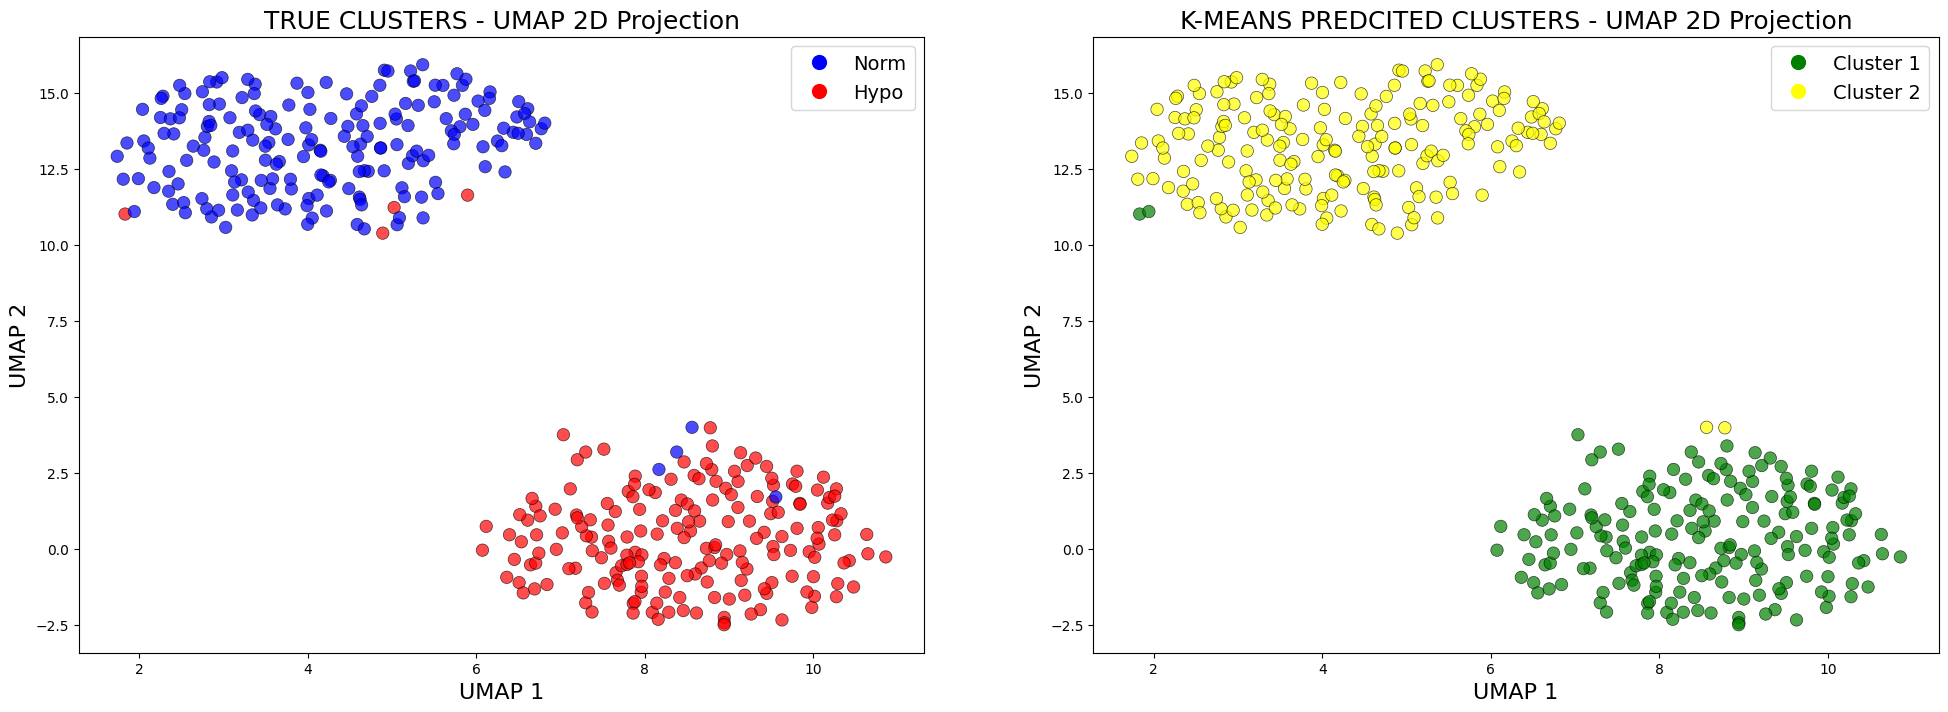

In [ ]:
# Visualize 2D projections side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# UMAP 2D
axes[0].scatter(umap_embedding_2d_M[:, 0], umap_embedding_2d_M[:, 1], s=80, alpha=0.7, c=colors_MCF7, edgecolor='k', linewidth=0.5)
axes[0].set_xlabel("UMAP 1", fontsize=16)
axes[0].set_ylabel("UMAP 2", fontsize=16)
axes[0].set_title("TRUE CLUSTERS - UMAP 2D Projection", fontsize=18)
axes[0].legend(handles=legend_elements, loc='best', fontsize=14)

axes[1].scatter(umap_embedding_2d_M[:, 0], umap_embedding_2d_M[:, 1], s=80, alpha=0.7, c=colors_kmeans_M, edgecolor='k', linewidth=0.5)
axes[1].set_xlabel("UMAP 1", fontsize=16)
axes[1].set_ylabel("UMAP 2", fontsize=16)
axes[1].set_title("K-MEANS PREDCITED CLUSTERS - UMAP 2D Projection", fontsize=18)
axes[1].legend(handles=legend_elements_3, loc='best', fontsize=14)
plt.show()

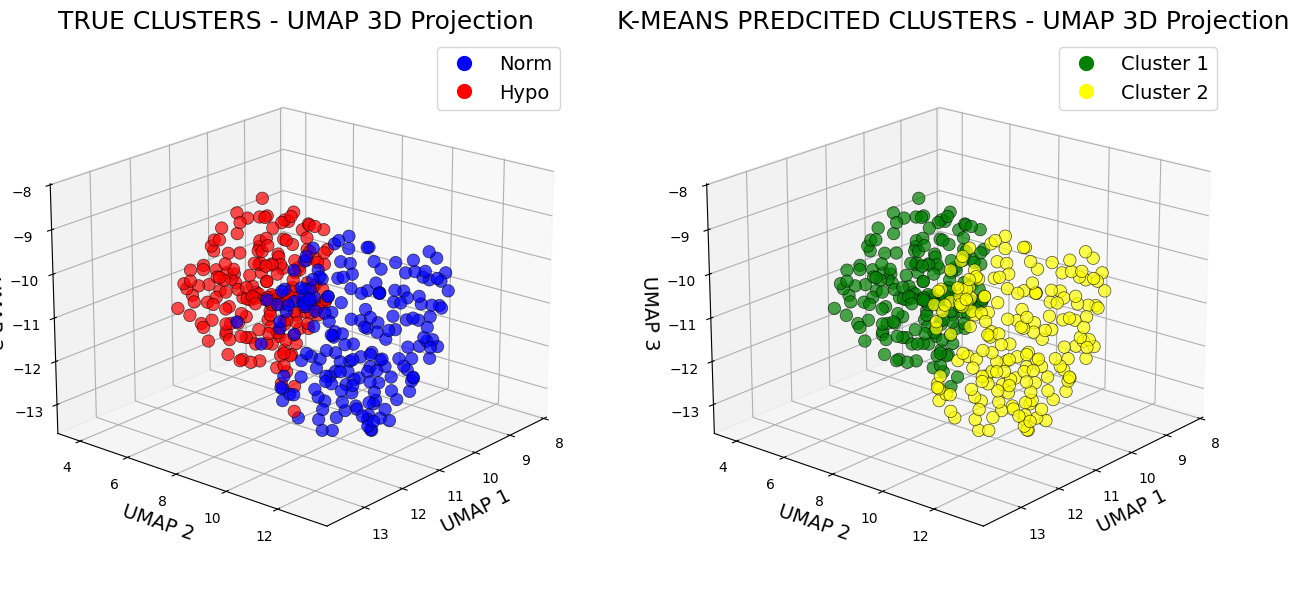

In [ ]:
# Visualize 3D projections side by side
fig = plt.figure(figsize=(24, 8))

# UMAP 3D
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(
    umap_embedding_3d_M[:, 0],
    umap_embedding_3d_M[:, 1],
    umap_embedding_3d_M[:, 2],
    c=colors_MCF7, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax1.set_xlabel("UMAP 1", fontsize=14)
ax1.set_ylabel("UMAP 2", fontsize=14)
ax1.set_zlabel("UMAP 3", fontsize=14)
ax1.set_title("TRUE CLUSTERS - UMAP 3D Projection", fontsize=18)
ax1.view_init(elev=20, azim=40)
ax1.legend(handles=legend_elements, loc='upper right', fontsize=14)

# t-SNE 3D
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(
    umap_embedding_3d_M[:, 0],
    umap_embedding_3d_M[:, 1],
    umap_embedding_3d_M[:, 2],
    c=colors_kmeans_M, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax2.set_xlabel("UMAP 1", fontsize=14)
ax2.set_ylabel("UMAP 2", fontsize=14)
ax2.set_zlabel("UMAP 3", fontsize=14)
ax2.set_title("K-MEANS PREDCITED CLUSTERS - UMAP 3D Projection", fontsize=18)
ax2.view_init(elev=20, azim=40)
ax2.legend(handles=legend_elements_3, loc='upper right', fontsize=14)

plt.show()

Final Comment:
Overall